In [108]:
# BMGT438a/ENES489a - Final Exam - Fall 2021
#
# Please answer the questions found here in this exam, save this notebook
# as a pdf, and upload it to ELMS.
#
# It may help you think about this as if it were a datathon or a QUEST client
# be sure to take a look a the website:
# https://prep-response-portal.napsgfoundation.org/datasets/geoplatform::national-bridge-inventory-nbi-bridges/about
# to get a better idea of the variables in the full dataset as well as the possible
# ways to explore the data
# you may also want to look at how a Maryland-only subset can be taken from this full dataset here:
# https://data-maryland.opendata.arcgis.com/datasets/maryland-bridge-structures-2


In [109]:
# here are some of the libraries you will need but there may be others
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score)
from sklearn.decomposition import PCA


from scipy.stats import norm
warnings.filterwarnings('ignore')

In [110]:
# we will help you out by looking only at the Maryland subset of the data
# This contains data of bridges in Maryland from as late as 1990s to 2018.
df = pd.read_csv('MD_Bridge_Data.csv')
# while there are many columns here, we can focus on just a few:
df = df[['SUFFICIENCY_RATING', 'YEAR', 'ADT_029', 'STRUCTURE_KIND_043A', 'MIN_NAV_CLR_MT_116']]
# here is what each variable means:
# SUFFICIENCY_RATING:  ratio data 0-100 that measures how sufficient is this structure for the traffic it carries
# YEAR:  the year the data was collected
# ADT_029:  average daily traffic
# STRUCTURE_KIND_043A is categorical and is mapped as follows
# 1: Concrete
# 2: Concrete cont.
# 3: Steel
# 4: Steel cont.
# 5: PS concrete
# 6: PS concrete cont.
# 7: Wood or Timber
# 8: Masonry
# 9: Aluminum/ Iron
# 0: Other
# MIN_NAV_CLR_MT_116:  bridge clearance

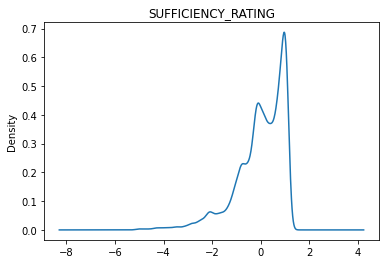

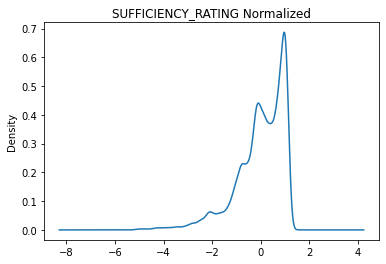

In [128]:
# Question 1:  Take a look at the skewness of the SUFFICIENCY_RATING variable and make
# any appropriate transformation in order to make it normal so we can use it for OLS

df.skew()
df['SUFFICIENCY_RATING'].plot(kind = 'kde')
plt.title('SUFFICIENCY_RATING')
plt.show()
print()
normalized_df = (df-df.mean())/df.std()
df = normalized_df
df['SUFFICIENCY_RATING'].plot(kind = 'kde')
plt.title('SUFFICIENCY_RATING Normalized')
plt.show()

In [123]:
# Question 2:  Use the categorical variable of STRUCTURE_KIND_043A to create dummy
# variables for an OLS
pd.get_dummies(df, columns = ['STRUCTURE_KIND_043A'], drop_first=True)

YVar = df[['SUFFICIENCY_RATING']]
XVar = sm.add_constant(df[['STRUCTURE_KIND_043A']])

In [124]:
# Question 3:  Run and OLS using the results from Question 1 as a dependent variable and from
# Question 2 as independent variables as well as the other independent variables in the dataframe.

LinearModel = sm.OLS(YVar, XVar, missing = 'drop').fit()
print(LinearModel.summary())

                            OLS Regression Results                            
Dep. Variable:     SUFFICIENCY_RATING   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     82.03
Date:                Sat, 18 Dec 2021   Prob (F-statistic):           1.39e-19
Time:                        21:56:50   Log-Likelihood:                -67535.
No. Observations:               47625   AIC:                         1.351e+05
Df Residuals:                   47623   BIC:                         1.351e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                8.677e-05    

,SUFFICIENCY_RATING,YEAR,ADT_029,STRUCTURE_KIND_043A,MIN_NAV_CLR_MT_116
SUFFICIENCY_RATING,1.000000,0.024541,-0.041821,0.041468,0.026265
YEAR,0.024541,1.000000,0.009227,0.014294,-0.011739
ADT_029,-0.041821,0.009227,1.000000,-0.015045,-0.045457
STRUCTURE_KIND_043A,0.041468,0.014294,-0.015045,1.000000,0.111792
MIN_NAV_CLR_MT_116,0.026265,-0.011739,-0.045457,0.111792,1.000000


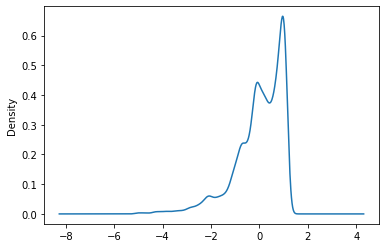

In [114]:
# Question 4:  Take a look at the residuals from Question 3 and plot the distribution of results.
# Are there any problems or concerns?  If yes, what are they?  Would a multicolinarity test help?

## Yes there are problems, the R-squared value is 0.002, which indicates low 
## correlation between independent and dependent variables. A correlation matrix would help. 

LinearModel.resid.plot.kde()

df.corr()

In [115]:
# Question 5:  Do a data transformation of the SUFFICIENCY_RATING to turn it into a categorical
# variable that is 0 if SUFFICIENCY_RATING < 85 and 1 if SUFFICIENCY_RATING >= 85

for idx, row in df.iterrows():
  if (df.at[idx,'SUFFICIENCY_RATING']) < 85:
    df.loc[idx, 'SUFFICIENCY_RATING'] = 0
  else:
    df.loc[idx, 'SUFFICIENCY_RATING'] = 1

In [116]:
# Question 6:  Split the dataframe into two parts:  training (80%) and a testing (20%)
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [117]:
# Question 7:  Run a logistic regression of the training data with the dependent variable coming
# from Question 5 and the independent variables that you used in Question 3
fn = ['STRUCTURE_KIND_043A']
cn = ['SUFFICIENCY_RATING']

x_train = train[fn]
y_train = train[cn]
x_test = test[fn]
y_test = test[cn]

LogisticModel = sm.Logit(y_train, x_train).fit()
print(LogisticModel.summary())

Optimization terminated successfully.
         Current function value: 0.693112
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:     SUFFICIENCY_RATING   No. Observations:                42421
Model:                          Logit   Df Residuals:                    42420
Method:                           MLE   Df Model:                            0
Date:                Sat, 18 Dec 2021   Pseudo R-squ.:                  -1.103
Time:                        21:53:39   Log-Likelihood:                -29402.
converged:                       True   LL-Null:                       -13980.
Covariance Type:            nonrobust   LLR p-value:                       nan
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
STRUCTURE_KIND_043A     0.0168      0.010      1.734      0.083      -0.002       0.036


This is the test accuracy of the model: 63.79%

This is what the confusion matrix looks like: 


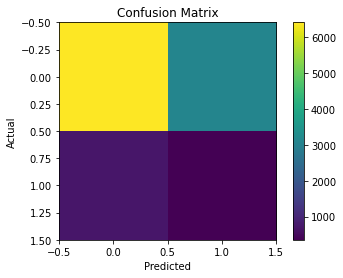

In [127]:
# Question 8:  What is the accuracy of this model?  What does the confusion matrix look like?

YPred = LogisticModel.predict(x_test)
compare = pd.concat([y_test, YPred], axis=1)
compare = compare.rename(columns={0: 'prediction'})
compare['difference'] = compare['SUFFICIENCY_RATING'] - compare['prediction']
compare.sort_values(by=['difference'])

prediction = list(map(round, YPred)) 

# confusion matrix 
cm = confusion_matrix(y_test, prediction)  

#print ("Confusion Matrix : \n", cm)  
print('This is the test accuracy of the model: {:.2%}'.format(accuracy_score(y_test, prediction)))

print('\nThis is what the confusion matrix looks like: ')
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [119]:
# Question 9:  If you go back to the full dataframe:
# df = pd.read_csv('MD_Bridge_Data.csv')
# you will note that there are actually 143 columns.  Pick 10 of these columns and reduce the 
# number of dimensions to two.

df = pd.read_csv('MD_Bridge_Data.csv')

new_df = pd.DataFrame()

new_df['RECORD_TYPE_005A'] = df['RECORD_TYPE_005A']
new_df['ROUTE_PREFIX_005B'] = df['ROUTE_PREFIX_005B']
new_df['SERVICE_LEVEL_005C'] = df['SERVICE_LEVEL_005C']
new_df['MAINTENANCE_021'] = df['MAINTENANCE_021']
new_df['OWNER_022'] = df['OWNER_022']
new_df['HISTORY_037'] = df['HISTORY_037']
new_df['SERVICE_ON_042A'] = df['SERVICE_ON_042A']
new_df['SERVICE_UND_042B'] = df['SERVICE_UND_042B']
new_df['STRUCTURE_KIND_043A'] = df['STRUCTURE_KIND_043A']
new_df['STRUCTURE_TYPE_043B'] = df['STRUCTURE_TYPE_043B']

x = new_df.values

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal component %s' % (x+1) for x in range(0, len(pca.components_))])


principalDf

,Principal component 1,Principal component 2
0,96.770148,0.158532
1,96.827769,-1.020101
2,95.968152,17.194237
3,96.777486,0.007907
4,96.817378,-0.618668
...,...,...
53022,97.514833,17.077951
53023,98.347744,-0.716924
53024,97.514833,17.077951
53025,97.514833,17.077951


In [120]:
# Question 10:  When is or was your client close-out meeting?  If it happened already, how did it
# go?  If you haven't done it yet, when will it be and what do you expect to come of it?

# Our client close-out meeting was on December 17 at 4:30pm. It went well! We went over our poster 
# and appendix of our presentation. We followed up with sending over all our deliverables.

In [121]:
# Don't forget to complete the final peer review!

# Done!